# Project 4: Web Scraping Indeed.com & Predicting Salaries

In Project 4, we practice two major skills: collecting data via  web scraping and building a binary predictor with Logistic Regression.

We will collect salary information on data science jobs in a variety of markets. Using location, title, and job summary, we'll predict the salary of the job. For job posting sites, this is extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), extrapolating expected salary can help guide negotiations.

Normally, we can use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Q: Why would we want this to be a classification problem?
- A: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Section one focuses on scraping Indeed.com; then we use listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

Scrape job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries. First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract.

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist&l=Atlanta%2C+GA"

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
from __future__ import division
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.preprocessing import scale

In [3]:
# read site in soup
r = requests.get(URL)
soup = BeautifulSoup(r.content, "lxml")

# Append to the full set of results
results = soup.findAll('div', { "class" : "result" })


Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some of the more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```

- Make sure these functions are robust and can handle cases where the data/field may not be available
- Test the functions on the results above

In [4]:
# get text
def extract_text(el):
    if el:
        return el.text.strip()
    else:
        return ''
        
# company
def get_company_from_result(result):
    return extract_text(result.find('span', {'class' : 'company'}))

# location
def get_location_from_result(result):
    return extract_text(result.find('span', {'class' : 'location'}))



# summary
def get_summary_from_result(result):
    return extract_text(result.find('span', {'class' : 'summary'}))



# title
def get_title_from_result(result):
    return extract_text(result.find('a', {'data-tn-element' : 'jobTitle'}))



# get salary if exists
def get_salary_from_result(result):
    salary_table = result.find('td', {'class' : 'snip'})
    if salary_table:
        snip = salary_table.find('nobr')
        if snip:
            return snip.text.strip()   
    return None

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results: the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try different city). The second controls where in the results to start and gives 10 results (so we can keep incrementing this by 10 to move further within the list).

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [5]:
# specify city
YOUR_CITY = ['Atlanta','Newark','Dallas','New+York','Houston', 'Boston','Connecticut',"San+Francisco",'Seattle','Cleveland','Tampa','Miami']

In [27]:
#create template URL and max number of results (pages) to pull
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
df =pd.DataFrame()
# for loop to pull data with bs4
for city in YOUR_CITY :
    for start in range(1,500,10):
        r = requests.get(url_template.format(city,start))
        # Grab the results from the request (as above)
        soup = BeautifulSoup(r.content)
        # Append to the full set of results
        results += soup.findAll('div', { "class" : "result" })

for element in  range(len(results)):
    company = get_company_from_result(results[element])
    location =get_location_from_result(results[element])
    summary=get_summary_from_result(results[element])
    title=get_title_from_result(results[element])
    salary=get_salary_from_result(results[element])
#     df = df.append({"Location":location,"Summary":summary,"Title":title,"Salary":salary},ignore_index = True)
    df = df.append({"Company":company,"Location":location,"Title":title,"Salary":salary,"Summary":summary},ignore_index = True)
df  

/Users/alexandertam/anaconda/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


,Company,Location,Salary,Summary,Title
0,Cotiviti,"Atlanta, GA",None,This is a pioneering data scientist who will p...,Data Scientist
1,MobileDev Power,"Atlanta, GA 30305",None,"Authoritative quantitative analysis skills, pa...",Data Scientist With Predictive Modeling
2,Home Depot,"Atlanta, GA 30354",None,3 years of experience in data mining and stati...,DATA SCIENTIST
3,FraudScope,"Atlanta, GA",None,Experience with healthcare-related data and fa...,Data Scientist
4,Centers for Disease Control and Prevention,"Atlanta, GA","$104,349 - $135,656 a year",Identify and analyze public health issues and ...,Health Scientist
5,Infor,"Atlanta, GA",None,Senior Data Scientist. Working closely with Pr...,Sr. Data Scientist
6,Northrop Grumman,"Atlanta, GA",None,Responsible for working with CDC antimicrobial...,Scientific Data Analyst
7,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year",Whether we are protecting the American people ...,Statistician (Health)
8,IgnitionOne,"Atlanta, GA",None,Have experience with predictive modelling / da...,Data Scientist
9,Turner,"Atlanta, GA 30319",None,"Turner's Consumer Insights, Research and Analy...","Manager, Consumer Insights & Statistical Analysis"


In [28]:
df.head(2)

,Company,Location,Salary,Summary,Title
0,Cotiviti,"Atlanta, GA",None,This is a pioneering data scientist who will p...,Data Scientist
1,MobileDev Power,"Atlanta, GA 30305",None,"Authoritative quantitative analysis skills, pa...",Data Scientist With Predictive Modeling


In [29]:
# for drop the null values
df1 = df.dropna()
df1.shape

(275, 5)

In [30]:
# drop the duplicates
df2 = df1.drop_duplicates()
df2.shape

(220, 5)

In [31]:
df2

,Company,Location,Salary,Summary,Title
4,Centers for Disease Control and Prevention,"Atlanta, GA","$104,349 - $135,656 a year",Identify and analyze public health issues and ...,Health Scientist
7,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year",Whether we are protecting the American people ...,Statistician (Health)
25,Emory University,"Atlanta, GA","$105,300 a year","Will support multiple studies, including studi...",Epidemiologist
36,Centers for Disease Control and Prevention,"Atlanta, GA","$104,349 - $135,656 a year",Lead scientists and program consultants in var...,Health Scientist
40,Analytic Recruiting,"Alpharetta, GA","$75,000 - $90,000 a year",Junior Data Scientist sought by Fortune 500 co...,Junior Data Scientist
48,Centers for Disease Control and Prevention,"Atlanta, GA","$74,260 - $96,538 a year",As Behavioral Scientist you will:. Identify an...,Behavioral Scientist
55,Smith Hanley Associates,"Atlanta, GA","$75,000 - $100,000 a year",-Post degree business based experience doing d...,Marketing Statistician
86,Analytic Recruiting,"Atlanta, GA","$100,000 - $125,000 a year","Python, data mining, data science; The data Sc...",Senior Data Scientist
87,Emory University,"Atlanta, GA","$85,500 a year",Staff Scientists will have leadership responsi...,Staff Scientist (Goldsmith Lab)
94,Stackfolio,"Atlanta, GA 30308 (Old Fourth Ward area)","$80,000 a year",We are looking for a bright and experienced da...,Lead Data Scientist


#### Complete the following code to collect results from multiple cities and start points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

In [32]:
# Filter to only the rows that have salary entries

# Remove duplicates

# Filter out salary entries referring to week, hour or month
df2 = df2[~(df2.Salary.astype('str').str.contains('hour'))]
df2 = df2[~(df2.Salary.astype('str').str.contains('month'))]
df2 = df2[~(df2.Salary.astype('str').str.contains('week'))]

df2.shape

(161, 5)

In [33]:
df2

,Company,Location,Salary,Summary,Title
4,Centers for Disease Control and Prevention,"Atlanta, GA","$104,349 - $135,656 a year",Identify and analyze public health issues and ...,Health Scientist
7,Centers for Disease Control and Prevention,"Atlanta, GA","$88,305 - $114,802 a year",Whether we are protecting the American people ...,Statistician (Health)
25,Emory University,"Atlanta, GA","$105,300 a year","Will support multiple studies, including studi...",Epidemiologist
36,Centers for Disease Control and Prevention,"Atlanta, GA","$104,349 - $135,656 a year",Lead scientists and program consultants in var...,Health Scientist
40,Analytic Recruiting,"Alpharetta, GA","$75,000 - $90,000 a year",Junior Data Scientist sought by Fortune 500 co...,Junior Data Scientist
48,Centers for Disease Control and Prevention,"Atlanta, GA","$74,260 - $96,538 a year",As Behavioral Scientist you will:. Identify an...,Behavioral Scientist
55,Smith Hanley Associates,"Atlanta, GA","$75,000 - $100,000 a year",-Post degree business based experience doing d...,Marketing Statistician
86,Analytic Recruiting,"Atlanta, GA","$100,000 - $125,000 a year","Python, data mining, data science; The data Sc...",Senior Data Scientist
87,Emory University,"Atlanta, GA","$85,500 a year",Staff Scientists will have leadership responsi...,Staff Scientist (Goldsmith Lab)
94,Stackfolio,"Atlanta, GA 30308 (Old Fourth Ward area)","$80,000 a year",We are looking for a bright and experienced da...,Lead Data Scientist


 Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [34]:
# for getting average salary

In [35]:
import re
import numpy as np
def extract_salary_average(salary_string):
    regex = r'\$([0-9]+,[0-9]+)'   
    matches = re.findall(regex, salary_string)
    return np.mean([float(salary.replace(',', '')) for salary in matches ])
    return matches

In [36]:

l1 = []
for i in df2["Salary"]:
    a = extract_salary_average(i)
    l1.append(a)
    
len(l1 ) 
df2["Salary"] = l1

In [37]:
df2["Salary"] = df2["Salary"].astype(float)

In [38]:
# median salary from salary column.
median_Salary = df2["Salary"].median()

In [39]:
type(median_Salary)

float

In [40]:
df2["Salary_class"] = df2["Salary"].map(lambda x: 1 if x>=median_Salary else 0)

In [41]:
# save scraped results as a CSV for Tableau/external viz
df2.to_csv('indeed salary_file', encoding='utf-8')

In [42]:
# load the file
salary_Data = pd.read_csv("indeed salary_file")

In [43]:
salary_Data.shape

(161, 7)

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

## Predicting salaries using Logistic Regression

In [44]:
del salary_Data["Unnamed: 0"]

In [45]:
# for creating new column as city and state
l3 =[]
l4 = []
for i in salary_Data["Location"]:
    city , state = i.split(", ")
    l3.append(city)
    l4.append(state)
salary_Data["City"] = l3
salary_Data["State"] = l4


salary_Data.head(2)

,Company,Location,Salary,Summary,Title,Salary_class,City,State
0,Centers for Disease Control and Prevention,"Atlanta, GA",120002.5,Identify and analyze public health issues and ...,Health Scientist,1,Atlanta,GA
1,Centers for Disease Control and Prevention,"Atlanta, GA",101553.5,Whether we are protecting the American people ...,Statistician (Health),1,Atlanta,GA


In [46]:
# Load in the the data of scraped salaries 

salary_Data.head()
salary_Data.dtypes

Company          object
Location         object
Salary          float64
Summary          object
Title            object
Salary_class      int64
City             object
State            object
dtype: object

In [47]:
# for state like GA,NJ.
salary_Data['State']= salary_Data["State"].str[:2]
salary_Data.head(2)

,Company,Location,Salary,Summary,Title,Salary_class,City,State
0,Centers for Disease Control and Prevention,"Atlanta, GA",120002.5,Identify and analyze public health issues and ...,Health Scientist,1,Atlanta,GA
1,Centers for Disease Control and Prevention,"Atlanta, GA",101553.5,Whether we are protecting the American people ...,Statistician (Health),1,Atlanta,GA


It is 50% if we guess randomly, half the salaries will be below the median and half will be above.

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [50]:
salary_Data["State"] = salary_Data["State"].astype("category")



In [51]:

dummies = pd.get_dummies(salary_Data['State'])
dummies[0:3]

,CA,CT,FL,GA,MA,NJ,NY,OH,TX,WA
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
salary_Data1 = pd.concat([salary_Data,dummies], axis=1)
salary_Data1.head(2)

,Company,Location,Salary,Summary,Title,Salary_class,City,State,CA,CT,FL,GA,MA,NJ,NY,OH,TX,WA
0,Centers for Disease Control and Prevention,"Atlanta, GA",120002.5,Identify and analyze public health issues and ...,Health Scientist,1,Atlanta,GA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Centers for Disease Control and Prevention,"Atlanta, GA",101553.5,Whether we are protecting the American people ...,Statistician (Health),1,Atlanta,GA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
salary_Data1["State"].value_counts()

NY    53
MA    20
GA    20
TX    14
FL    14
WA    13
CA    12
NJ     8
CT     6
OH     1
Name: State, dtype: int64

In [54]:
pd.crosstab(salary_Data1["Salary_class"], salary_Data1["State"], rownames=["salary_Data1"])

State,CA,CT,FL,GA,MA,NJ,NY,OH,TX,WA
salary_Data1,,,,,,,,,,
0,1,3,11,12,8,4,24,0,8,7
1,11,3,3,8,12,4,29,1,6,6


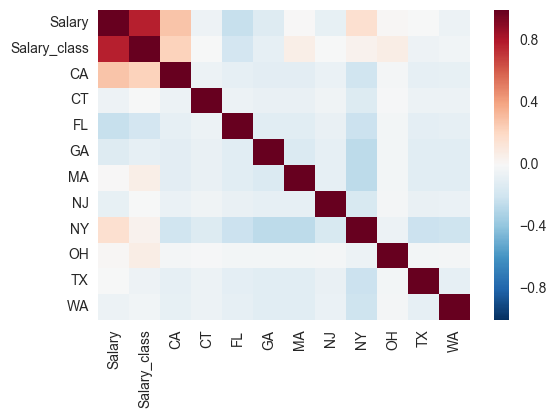

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

sns.heatmap(salary_Data1.corr())



In [56]:
salary_Data1.head(1)

,Company,Location,Salary,Summary,Title,Salary_class,City,State,CA,CT,FL,GA,MA,NJ,NY,OH,TX,WA
0,Centers for Disease Control and Prevention,"Atlanta, GA",120002.5,Identify and analyze public health issues and ...,Health Scientist,1,Atlanta,GA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
salary_Data1.corr()

,Salary,Salary_class,CA,CT,FL,GA,MA,NJ,NY,OH,TX,WA
Salary,1.000000,0.774097,0.283148,-0.051477,-0.233154,-0.127410,0.003180,-0.085451,0.163977,0.008187,-0.006919,-0.055514
Salary_class,0.774097,1.000000,0.227788,-0.006113,-0.186020,-0.087063,0.063659,-0.007105,0.044353,0.076639,-0.053697,-0.032018
CA,0.283148,0.227788,1.000000,-0.055835,-0.087580,-0.106882,-0.106882,-0.064893,-0.198803,-0.022436,-0.087580,-0.084108
CT,-0.051477,-0.006113,-0.055835,1.000000,-0.060718,-0.074099,-0.074099,-0.044989,-0.137827,-0.015554,-0.060718,-0.058311
FL,-0.233154,-0.186020,-0.087580,-0.060718,1.000000,-0.116228,-0.116228,-0.070567,-0.216188,-0.024398,-0.095238,-0.091463
GA,-0.127410,-0.087063,-0.106882,-0.074099,-0.116228,1.000000,-0.141844,-0.086120,-0.263834,-0.029775,-0.116228,-0.111621
MA,0.003180,0.063659,-0.106882,-0.074099,-0.116228,-0.141844,1.000000,-0.086120,-0.263834,-0.029775,-0.116228,-0.111621
NJ,-0.085451,-0.007105,-0.064893,-0.044989,-0.070567,-0.086120,-0.086120,1.000000,-0.160186,-0.018078,-0.070567,-0.067770
NY,0.163977,0.044353,-0.198803,-0.137827,-0.216188,-0.263834,-0.263834,-0.160186,1.000000,-0.055382,-0.216188,-0.207619
OH,0.008187,0.076639,-0.022436,-0.015554,-0.024398,-0.029775,-0.029775,-0.018078,-0.055382,1.000000,-0.024398,-0.023430


In [58]:
import statsmodels.formula.api as sm
Y = salary_Data1["Salary_class"]
model = sm.logit("Y~MA+NY+NJ+WA+CA+CT+TX+GA",data = salary_Data1).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.644714
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                  161
Model:                          Logit   Df Residuals:                      152
Method:                           MLE   Df Model:                            8
Date:                Tue, 22 Nov 2016   Pseudo R-squ.:                 0.06923
Time:                        18:17:33   Log-Likelihood:                -103.80
converged:                       True   LL-Null:                       -111.52
                                        LLR p-value:                   0.05113
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.0116      0.584     -1.733      0.083        -2.156     0.133
MA             1.4171      0.741      1.912      0.056        -0.035     2.870
NY             1.2008      0.646      1.859      0.063        -0.065     2.467
NJ             1.0116      0.917      1.103      0.270        -0.786     2.809
WA             0.8575      0.806      1.063      0.288        -0.723     2.438
CA             3.4095      1.197      2.849      0.004         1.064     5.755
CT             1.0116      1.004      1.008      0.314        -0.956     2.979
TX             0.7239      0.795      0.910      0.363        -0.835     2.283
GA             0.6061      0.741      0.818      0.413        -0.846     2.059
==============================================================================
"""

In [59]:
#AT - Dont forget to drop one of the states for the base case!

after analyzing  coefficients we got to know that State of CA is highely correlated with maximum probability of getting a median or above incomes.  and in State of TX the probability is low.  


#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' or 'Manager' is in the title 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [60]:
#Created 4 new columns for designation (Sr,Mgr,Dir and analyst)
salary_Data1['is_senior'] = salary_Data1['Title'].str.contains('Senior|Lead|Sr.',case=False).astype(int)
salary_Data1['is_manager'] = salary_Data1['Title'].str.contains('Manager',case=False).astype(int)
salary_Data1['is_dir'] = salary_Data1['Title'].str.contains('Director',case=False).astype(int)
salary_Data1['is_Analyst'] = salary_Data1['Title'].str.contains('Analyst',case=False).astype(int)

salary_Data1.head(2)


,Company,Location,Salary,Summary,Title,Salary_class,City,State,CA,CT,...,MA,NJ,NY,OH,TX,WA,is_senior,is_manager,is_dir,is_Analyst
0,Centers for Disease Control and Prevention,"Atlanta, GA",120002.5,Identify and analyze public health issues and ...,Health Scientist,1,Atlanta,GA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,Centers for Disease Control and Prevention,"Atlanta, GA",101553.5,Whether we are protecting the American people ...,Statistician (Health),1,Atlanta,GA,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


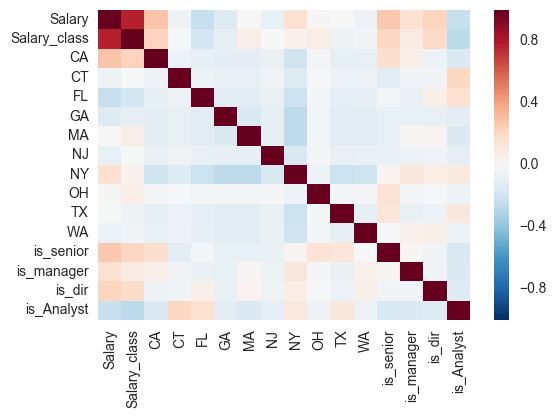

In [61]:
import matplotlib.pyplot as plt
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# Seaborn is a nice package for plotting, but you have to use pip to install
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
sns.heatmap(salary_Data1.corr())

In [62]:
#AT - good correlations, but point out the correlations you see and the changes from the earlier heatmap

In [63]:
salary_Data1.describe()

,Salary,Salary_class,CA,CT,FL,GA,MA,NJ,NY,OH,TX,WA,is_senior,is_manager,is_dir,is_Analyst
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,105155.956522,0.515528,0.074534,0.037267,0.086957,0.124224,0.124224,0.049689,0.329193,0.006211,0.086957,0.080745,0.248447,0.043478,0.037267,0.329193
std,46924.723134,0.501318,0.263458,0.190007,0.282650,0.330866,0.330866,0.217981,0.471386,0.078811,0.282650,0.273294,0.433461,0.204567,0.190007,0.471386
min,24000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70286.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,97500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,135000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,300000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


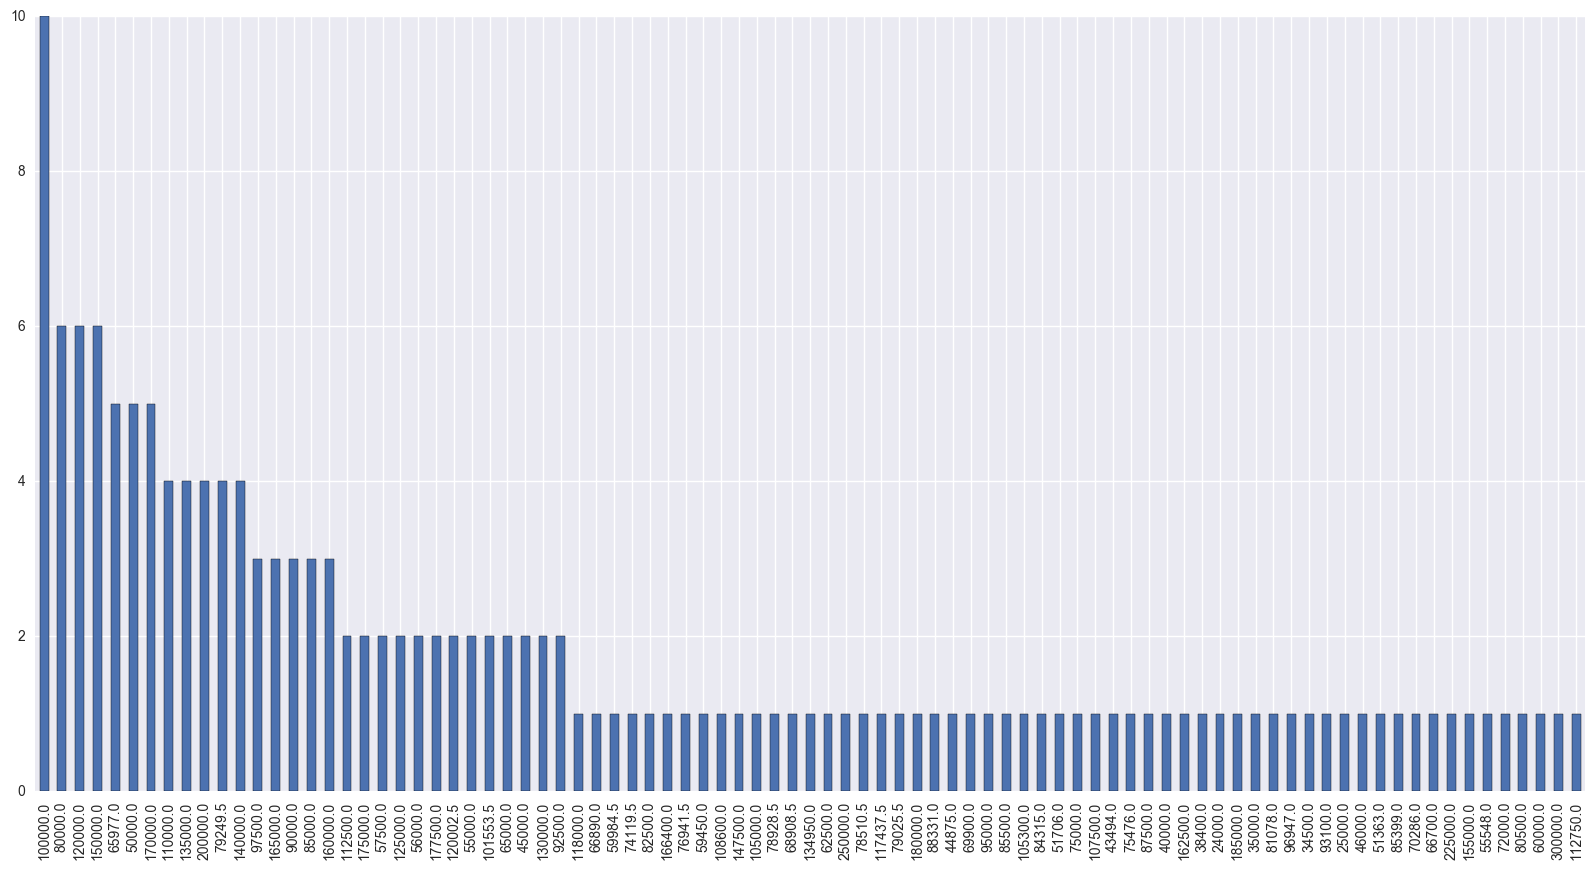

In [64]:
# plot for Salary counts
salary_Data1["Salary"].value_counts().plot(kind='bar',figsize = (20,10))
plt.show()

In [65]:
#AT - this would be better as a histogram so we could see the tales on either side

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [66]:
# Using Logistic Regression model 

from sklearn.linear_model import LogisticRegression

X = salary_Data1[['is_senior','is_dir','is_Analyst','is_manager',"MA","NJ","NY","WA","CA","GA"]]
Y = salary_Data1["Salary_class"]
logreg = LogisticRegression(random_state=77,C=5)
logreg.fit(X, Y)
Y_pred1 = logreg.predict(X)
ypro = logreg.predict_proba(X)

logreg.coef_
 

array([[ 0.84849225,  2.35561615, -0.85909592,  0.39993432,  0.59133392,
         0.26142676,  0.49449198, -0.06030026,  2.00513828, -0.08720558]])

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [67]:
#Using Train test validation method to build our model
from sklearn.cross_validation import cross_val_score


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33,random_state=50)
logreg_cv =  LogisticRegressionCV(cv=5,Cs=5,random_state=50)
logreg_cv.fit(X_train,Y_train)
#score = logreg_cv()
Y_pred = logreg_cv.predict(X_test)
ypro = logreg_cv.predict_proba(X_test)
Y_score = logreg_cv.decision_function(X_test)


In [68]:
logreg_cv.coef_

array([[ 1.04568781,  7.91756198, -0.26426602,  0.81949349,  1.03096492,
         1.18303233,  0.82766045, -0.06300106,  2.02211454,  0.20343172]])

In [69]:
# Creating confusion matrix
from sklearn.metrics import confusion_matrix
conmat = np.array(confusion_matrix(Y_test, Y_pred))
confusion = pd.DataFrame(conmat, index=['High_Salary', 'Low_salary'],
                         columns=['predicted_High', 'predicted_Low'])
confusion

,predicted_High,predicted_Low
High_Salary,19,12
Low_salary,5,18


In [71]:
# Identifying and printing True Positive Rate, False Positive rate  etc...
TP = confusion.ix['High_Salary', 'predicted_High']
FP = confusion.ix['Low_salary', 'predicted_High']
TN = confusion.ix['Low_salary', 'predicted_Low']
FN = confusion.ix['High_Salary', 'predicted_Low']
print(zip(['True Positives','False Positives','True Negatives','False Negatives'],
         [TP, FP, TN, FN]))

[('True Positives', 19), ('False Positives', 5), ('True Negatives', 18), ('False Negatives', 12)]


In [72]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
acc = accuracy_score(Y_test, Y_pred)
print "Accuracy" , acc
cls_rep = classification_report(Y_test, Y_pred)
print(cls_rep)

Accuracy 0.685185185185
             precision    recall  f1-score   support

          0       0.79      0.61      0.69        31
          1       0.60      0.78      0.68        23

avg / total       0.71      0.69      0.69        54



### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [73]:
# Building L2,L1 Regularization and comparing results
model_l2 = LogisticRegression(penalty = 'l2', C =1)
model_l2.fit(X_train,Y_train)
Y_predl2 = model_l2.predict(X_test)
yprol2 = model_l2.predict_proba(X_test)
accl2 = accuracy_score(Y_test, Y_pred)
Y_scorel2 = model_l2.decision_function(X_test)
# print "Accuracy for L2 :- " ,acc
# cls_rep = classification_report(Y_test, Y_pred)
# print(cls_rep)

print "****************************************************************************"
print "Accuracy for L2 :- " ,accl2
cls_rep = classification_report(Y_test, Y_predl2)
print "****************************************************************************"
print "Classification Report of Cross Validation  with L2:-" 
print "****************************************************************************"
print(cls_rep)
print "****************************************************************************"
print "Y Score  :-" 
print(Y_scorel2[0:10])



****************************************************************************
Accuracy for L2 :-  0.685185185185
****************************************************************************
Classification Report of Cross Validation  with L2:-
****************************************************************************
             precision    recall  f1-score   support

          0       0.80      0.65      0.71        31
          1       0.62      0.78      0.69        23

avg / total       0.72      0.70      0.70        54

****************************************************************************
Y Score  :-
[ 0.35506819 -0.02387495 -0.49454109 -0.05707872  0.35772152 -0.02387495
 -0.02387495 -0.24795652  1.80711037 -0.49454109]


In [74]:
model_l2.coef_

array([[ 0.74674858,  0.74791615, -0.43746238,  0.2996189 ,  0.4121469 ,
         0.41480023,  0.47066614, -0.20292246,  0.8178216 , -0.1908778 ]])

In [75]:
# L1 Regularizition
model_l1 = LogisticRegression(penalty = 'l1', C=1)
model_l1.fit(X_train,Y_train)
Y_predl1 = model_l1.predict(X_test)
yprol1 = model_l1.predict_proba(X_test)
Y_scorel1 =model_l1.decision_function(X_test)
accl1 = accuracy_score(Y_test, Y_pred)
print "****************************************************************************"
print "Accuracy for L1 :- " ,accl1
cls_rep = classification_report(Y_test, Y_predl1)
print "****************************************************************************"
print "Classification Report of Cross Validation  with L1 :-" 
print "****************************************************************************"
print(cls_rep)
print "****************************************************************************"
print "Y Score  :-" 
print(Y_scorel1[0:10])

#for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    

****************************************************************************
Accuracy for L1 :-  0.685185185185
****************************************************************************
Classification Report of Cross Validation  with L1 :-
****************************************************************************
             precision    recall  f1-score   support

          0       0.78      0.45      0.57        31
          1       0.53      0.83      0.64        23

avg / total       0.67      0.61      0.60        54

****************************************************************************
Y Score  :-
[ 0.16231233  0.00830974 -0.37796669  0.          0.          0.00830974
  0.00830974 -0.0173925   1.3405831  -0.37796669]


In [76]:
model_l1.coef_

array([[ 0.6970094 ,  0.23834104, -0.37796669,  0.        ,  0.16231233,
         0.        ,  0.38627643,  0.        ,  0.6435737 , -0.0173925 ]])

After the comparison of L1 and  L2 regularization we got to know accuracy score is high in L1. 

In [77]:
#AT - the accuracy for both ios the same, tell me abouth the difference in the coeeficients. the f1 score is higher for l2

/Users/alexandertam/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:4: DeprecationWarning: sklearn.metrics.metrics is deprecated and will be removed in 0.18. Please import from sklearn.metrics
  DeprecationWarning)


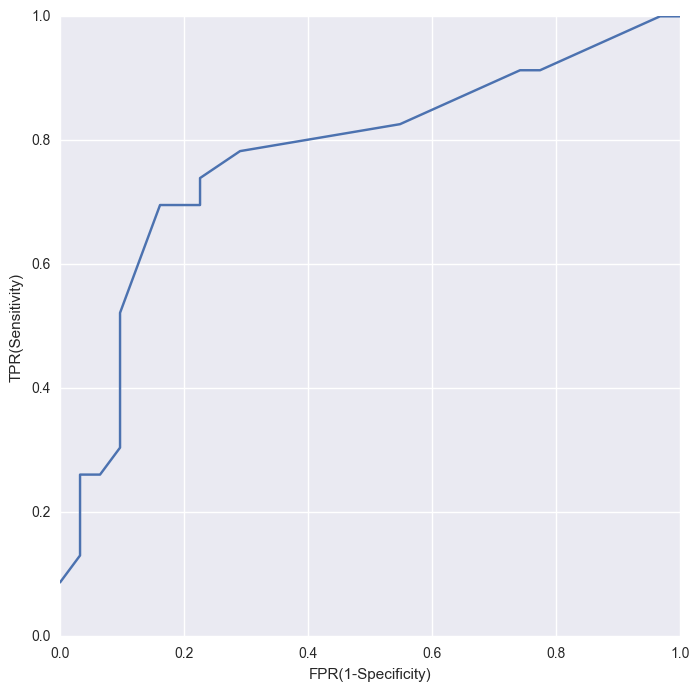

In [78]:
# ROC Curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,metrics,auc
FPR,TPR,thresholds  = metrics.roc_curve(Y_test,yprol1[:,1])
ROC_AUC = auc(FPR,TPR)

#print(ypro)
plt.figure(figsize=[8,8])
plt.plot(FPR,TPR)

plt.xlabel('FPR(1-Specificity)')
plt.ylabel('TPR(Sensitivity)')
plt.grid(True)
plt.show()

Accuracy is measured by the area under the ROC curve. An area of 1 represents a perfect test; an area of .5 represents Guess work
as per above curve Accuracy of model is 75%. L1 Model Accuracy truns out to be better then L2

In [79]:
#AT - there are methods that will tell you the actual AUC. Ask a fellow student to see their ROC curve

In [80]:
# Finding Best Parameters
from sklearn.grid_search import GridSearchCV
logreg = LogisticRegression()
C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty' :penalties, 'C' : C_vals}, verbose=True, cv=5, scoring="accuracy",n_jobs=-1)

In [81]:
#AT - NICE GRID SEARCH

In [96]:
gs.fit(X,Y)
gs.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished


{'C': 0.0001, 'penalty': 'l2'}

In [ ]:
#AT - this is what I got, {'C': 0.0001, 'penalty': 'l2'}

In [83]:
#according to GridSearch best perameters are C': 0.5, 'penalty': 'l1 use this perameter in our model

In [95]:
model_l1 = LogisticRegression(penalty = 'l1', C=.5)
model_l1.fit(X_train,Y_train)
score = cross_val_score
Y_pred = model_l1.predict(X_test)
ypro = model_l1.predict_proba(X_test)
Y_scorel1 = logreg_cv.decision_function(X_test)
acc = accuracy_score(Y_test, Y_pred)
print "Accuracy Score with cross validation L1 :-", acc
cls_rep = classification_report(Y_test, Y_pred)
print "****************************************************************************"
print "Classification Report of Cross Validation with L1 :-" 
print "****************************************************************************"
print(cls_rep)
print "****************************************************************************"
print "Y Score  :-" 
print(Y_scorel1[0:10])

Accuracy Score with cross validation L1 :- 0.592592592593
****************************************************************************
Classification Report of Cross Validation with L1 :-
****************************************************************************
             precision    recall  f1-score   support

          0       0.70      0.52      0.59        31
          1       0.52      0.70      0.59        23

avg / total       0.62      0.59      0.59        54

****************************************************************************
Y Score  :-
[ 0.444704   -0.02286649 -0.85052694 -0.58626092  0.5967714  -0.02286649
 -0.02286649 -0.38282921  3.30103492 -0.85052694]


In [88]:
#AT - this is a great score

# Tableau Story of Average Salary Per State.

In [89]:
%%html
<div class='tableauPlaceholder' id='viz1479781530744' style='position: relative'><noscript><a href='#'><img alt='Data Analysis of Datascience Job Across USA and there average salaries for each states. ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Av&#47;AverageSalaryMap&#47;Story1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='AverageSalaryMap&#47;Story1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Av&#47;AverageSalaryMap&#47;Story1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1479781530744');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1020px';vizElement.style.height='1033px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Blog Post:- 

https://preranashrivastava.wordpress.com/2016/11/22/collecting-data-by-scraping-a-website-and-building-a-binary-predictor-with-logistic-regression

#### Optional: Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients. Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary. Which entries have the highest predicted salaries?

# Bonus Section: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are most valuable? 

In [90]:
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform()

# for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
#     scores = cross_val_score(model, X_scaled, y, cv=3, scoring=metric)
#     print(metric, scores.mean(), scores.std())

In [91]:
# model.fit(X_scaled, y)

# df = pd.DataFrame({'features' : vectorizer.get_feature_names(), 'coef': model.coef_[0,:]})
# df.sort_values('coef', ascending=False, inplace=True)

In [92]:
# df.head()

In [93]:
# df.tail()

In [94]:
# # retest L1 and L2 regularization
# from sklearn.linear_model import LogisticRegressionCV

# model = LogisticRegressionCV()


Score: | 22/24
------|-------
Identify: Problem Statement and Hypothesis | 3
Acquire: Import Data using BeautifulSoup| 3
Parse: Clean and Organize Data| 3
Model: Perform Logistic Regression| 3
Evaluate: Logistic Regression Results	| 2
Present: Blog Report with Findings and Recommendations		| 2
Interactive Tableau visualizations | 3
Regularization | 3
Bonus: Countvectorizer  | 0

In [ ]:
#AT - Nice job!